# Data Collection

## Objectives

1. Fetch data from kaggle.
2. Prepare data for model training.

## Inputs

1. Authentication Kaggle JSON file

## Outputs

1. Image only datasets

## Comments

Kaggle dataset is already divided in train, validate and test folder. It is important to calculate ratios and redistribute if needed.

---

## Import packages

In [1]:
import numpy
import os

## Set working directory

In [2]:
print(os.getcwd())

/workspace/OCTreader/jupiter_notebooks


In [3]:
os.chdir('/workspace/OCTreader')
print(f'New working directory: {os.getcwd()}')

New working directory: /workspace/OCTreader


## Installing Kaggle

In [4]:
# install kaggle==1.5.12 package
%pip install kaggle==1.5.12

     |████████████████████████████████| 58 kB 1.9 MB/s eta 0:00:01
     |████████████████████████████████| 78 kB 2.7 MB/s eta 0:00:011
     |████████████████████████████████| 78 kB 9.0 MB/s  eta 0:00:01
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73049 sha256=cca4efd3eb3e4d2e9c67d99f2edd53985dbc6d1572580be7c44c662a23916d68
  Stored in directory: /workspace/.pyenv_mirror/pip_cache/wheels/29/da/11/144cc25aebdaeb4931b231e25fd34b394e6a5725cbb2f50106
Successfully built kaggle
You should consider upgrading via the '/home/gitpod/.pyenv/versions/3.8.12/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


## Configuring working directory and authentication for Kaggle

In [5]:
os.environ['KAGGLE_CONFIG_DIR'] = os.getcwd()
! chmod 600 kaggle.json

chmod: cannot access 'kaggle.json': No such file or directory


## Fetch data from Kaggle

In [6]:
# Variables containing kaggle data path and local directory to host input data
data_path = 'paultimothymooney/kermany2018/data'
destination_folder = 'inputs/OCTdata'
! kaggle datasets download -d {data_path} -p {destination_folder}

100%|█████████████████████████████████████▉| 10.8G/10.8G [05:32<00:00, 28.3MB/s]
100%|██████████████████████████████████████| 10.8G/10.8G [05:32<00:00, 35.0MB/s]


In [7]:
import zipfile

# Find the zip file with kaggle data
zip_kaggle_dataset = os.listdir(destination_folder)

with zipfile.ZipFile(destination_folder + '/' + zip_kaggle_dataset[0], 'r') as zip_ref:
    zip_ref.extractall(destination_folder)

os.remove(destination_folder + '/' + zip_kaggle_dataset[0])

## Remove redundant data

There are two folders with the same data, we will eliminate one.

In [12]:
# Listing existing folders
data_folders = os.listdir(destination_folder)
data_folders

['OCT2017 ', 'oct2017']

In [14]:
import shutil

# We will keep this folder
keeping_dir = 'OCT2017 '

for current_dir in os.listdir('inputs/OCTdata'):
    if current_dir != keeping_dir:
        shutil.rmtree('inputs/OCTdata/' + current_dir)


There is a trailing space in the data folder that is best to remove.

In [24]:
data_folders = os.listdir(destination_folder)

# Removing trainling space if found in folder's name
if  data_folders[0][-1] == ' ':
    os.rename(destination_folder + '/' + data_folders[0],
              destination_folder + '/' + data_folders[0][0: -1])

We check if the trailing space has been removed

In [25]:
data_folders = os.listdir(destination_folder)
data_folders[0]

'OCT2017'

# Data Cleaning and Split

Data is now divided in three folders: train, val and test. Each of these folders contains four folders for the different labels. In this step non-images files are removed and ratios of train, val and test are calculated.

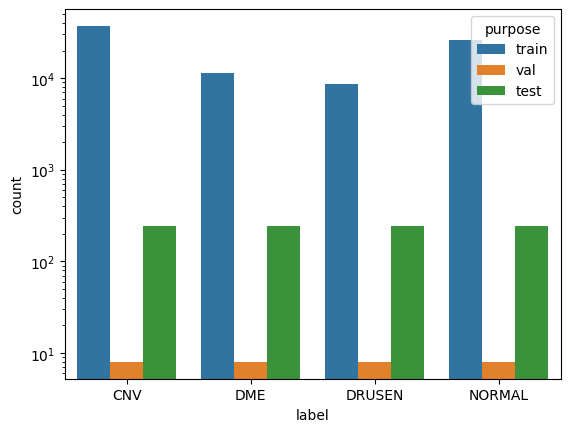

Viasualisation of images distribution across folders
Summary of images distribution across folders
         count    ratios
purpose                 
test       968  0.011458
train    83484  0.988163
val         32  0.000379


,ratios
purpose,
test,0.011458
train,0.988163
val,0.000379


In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def remove_non_images(data_dir):
    '''
    The function checks data_dir and removes
    any files without image extension
    and counts image files in folder
    '''
    image_extensions = ['jpeg', 'png', 'gif']
    image_count = 0
    for image_file in os.listdir(data_dir):
        if image_file.split('.')[1] in image_extensions:
            image_count += 1
        else:
            os.remove(data_dir + image_file)

    return image_count


def explore_directories(root_dir):
    '''
    Sweeps all directories calling the non_image removing function
    counts the total of images per folder and makes a summary on df    
    '''
    # empty dataframe
    df = pd.DataFrame(columns=['purpose', 'label', 'count'])
    labels = ['CNV', 'DME', 'DRUSEN', 'NORMAL']
    split_dirs = ['train', 'val', 'test']
    for split_dir in split_dirs:
        for label in labels:
            data_dir = root_dir + split_dir + '/' + label
            # count per label
            count = remove_non_images(data_dir)
            # add record of count per directory
            df = df.append({'purpose': split_dir, 'label': label, 'count': count}, ignore_index = True)

    # create a log plot to observe distribution of images
    sns.barplot(data=df, x='label', y='count', hue='purpose')
    plt.yscale('log')
    plt.show()
    print('Viasualisation of images distribution across folders')
    df_summary = (df.groupby(by=['purpose',]).sum().drop('label', axis=1))
    print('Summary of images distribution across folders')
    df_summary['ratios'] = df_summary['count']/df_summary['count'].sum()
    print(df_summary)
    return df_summary.drop('count', axis=1)


df_summary = explore_directories('inputs/OCTdata/OCT2017/')
df_summary


Expected ratios are train = 0.7, val = 0.1 and test = 0.2. If this condition is not met, the files need to be redistributed.

In [42]:
def check_split_ratios(df):
    '''
    Function checks if ratios in data satisfy the requirements
    and returns a boolean
    '''

    # defining split ratios and tolerance
    train_ratio, val_ratio = 0.7, 0.1
    tolerance = 0.02
    
    train_true = df.loc['train', 'ratios']
    val_true = df.loc['val', 'ratios']

    train_accept = (train_true < train_ratio + tolerance) and (train_true > train_ratio - tolerance)
    val_accept = (val_true < val_ratio + tolerance) and (val_true > val_ratio - tolerance)

    return train_accept and val_accept

def split_data_function():
    df = explore_directories('inputs/OCTdata/OCT2017/')
    right_split = check_split_ratios(df)

# def combine_dataset(root_dir):
#     labels = ['CNV', 'DME', 'DRUSEN', 'NORMAL']
#     split_dirs = ['train', 'val', 'test']
#     os.makedirs(root_dir + '/data')
#     for label in labels:
#         os.makedirs(root_dir + '/data/' + label)
#         for split_dir in split_dirs:
#             dir_path = root_dir + '/' + split_dir + '/' + label
#             for image_file in os.listdir(dir_path):
#                 shutil.move(dir_path + '/' + image_file, root_dir + '/data/' + label+ '/' + image_file)

# combine_dataset('inputs/OCTdata/OCT2017')
